# The Peaking Power-Plants

## Motivation

You are the boss of an electricity distribution company. Based on the contracts with the end-users, you know the demand on the amount of the electrical energy between hour $t$ and $(t+1)$ next day; i.e., you have vector $\bar{d} = (d_0, d_1, \dots, d_{23})$ of demands.

Your company owns several power-plants and wants to cover the demands by switching these plants on and off. There are two types of power-plants: `base` and `peak` plants (there are $n_{base}$ and $n_{peak}$ of these plants).

* **Base power-plants** (zdroje základního zatížení) are cheap, but it takes a long time to start them and turn them off; therefore, they need to be either turned on or turned off the whole day. These plants produce $e_{base}$ energy every hour and their running cost is $c_{base}$ every hour.
    
* **Peak power-plants** (špičkové zdroje) are fast, and can be turned on/off every hour, but typically the price is high. These plants produce $e_{peak}$ energy every hour and their running cost $c_{peak}$ (every hour).


The surplus energy is being stored in the batteries (storage) and can be used later. However, there is a loss modeled by parameter $\gamma \in [0,1]$. If $k$ units of energy leave the storage, only $\gamma \cdot k$ units can be used to cover demands (the rest, i.e., $(1-\gamma)\cdot k$, is lost).

The capacity of the storage is limited to $s_{max}$ units, and due to technological restrictions, it is impossible to take the energy from the storage and store it inside simultaneously. The produced energy needs to cover the demands or be stored in the batteries (energy cannot just vanish). The storage is empty at the beginning.

You want to minimize to total cost (turning the power-plants on/off) while covering all the demands.

## Input

You are given the following:

* $\mathbf{d} = (d_0,d_1,\dots,d_{23})$ – vector of demands
* $n_{base},n_{peak}$ – number of the respective power-plants
* $c_{base}, c_{peak}$ – cost needed for the running of the respective type of the plant (per hour)
* $e_{base}, e_{peak}$ – amount of energy generated by the respective type (per hour)
* $s_{max}$ – storage capacity
* $(1−\gamma)$ – energy loss of the storage (only $\gamma \cdot k$ energy units can be used out of $k$ units)

For the testing purposes, you can experiment with the following instance:

In [1]:
!pip install gurobipy
import gurobipy as g

Defaulting to user installation because normal site-packages is not writeable


In [5]:
d = [5, 5, 5, 5, 5, 10, 10, 15, 20, 20, 30, 30, 40, 50, 60, 60, 60, 50, 40, 30, 30, 20, 10, 5]

n_base = 10
e_base = 7
c_base = 2.0 / 24.0

n_peak = 40
e_peak = 2
c_peak = 12

s_max = 100

gamma = 0.75

## Output

Your goal is to find the number of `base` power-plants that should be active throughout the whole day, as well as the number of `peak` power-plants that should be active every hour such that the cost is minimized.

The **optimal solution** for the given instance is:

* $2$ active base power-plants
* $(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5, 8, 13, 7, 23, 23, 23, 18, 13, 8, 8, 3, 0, 0)$ active peak power-plants (every hour)

The corresponding cost is $1840$.

## Exercise

Implement the ILP modelfor the peaking power-plants problem, solve it and examine the solution.

In [15]:
# MODEL
m = g.Model()

# - ADD VARIABLES
b_active = m.addVar(lb=0, ub=n_base, vtype=g.GRB.INTEGER) # kolik je zapnuto elektraren
p_active = m.addVars(len(d), lb=0, ub=n_peak, vtype=g.GRB.INTEGER) # kolik produkuji peak elektrarny kazdou hodnotu
k_bat = m.addVars(len(d) + 1, vtype=g.GRB.CONTINUOUS, ub=s_max, lb=0) # aktualni kapacita baterky, resp. kolik je momentalne v baterce, index vetsi kvuli zmene
o_bat = m.addVars(len(d), vtype=g.GRB.CONTINUOUS, ub=s_max, lb=0) # kolik z baterie davam
i_bat = m.addVars(len(d), vtype=g.GRB.CONTINUOUS, ub=s_max, lb=0) # kolik do baterie nabijim
y = m.addVars(len(d), vtype=g.GRB.BINARY) # je v dane hodine baterie zapnuta nebo ne

# - ADD CONSTRAINTS

m.addConstr(k_bat[0]==0) # baterka je na zacatku vybita
for h in range(len(d)):
   m.addConstr(b_active*e_base + p_active[h]* e_peak + o_bat[h]*gamma - i_bat[h] == d[h])
   m.addConstr(k_bat[h] + i_bat[h] - o_bat[h] == k_bat[h+1])
   
   m.addConstr(i_bat[h]<=y[h]* s_max) # switcher baterky
   m.addConstr(o_bat[h]<=(1-y[h])* s_max) # switcher baterky

# - SET OBJECTIVE
m.setObjective(b_active * c_base * len(d) + p_active.sum() * c_peak)

m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 97 rows, 122 columns and 289 nonzeros
Model fingerprint: 0x0977425c
Variable types: 73 continuous, 49 integer (24 binary)
Coefficient statistics:
  Matrix range     [8e-01, 1e+02]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [5e+00, 1e+02]
Presolve removed 4 rows and 4 columns
Presolve time: 0.00s
Presolved: 93 rows, 118 columns, 279 nonzeros
Variable types: 69 continuous, 49 integer (23 binary)
Found heuristic solution: objective 3708.0000000

Root relaxation: objective 9.951744e+02, 73 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

## Solution visualization

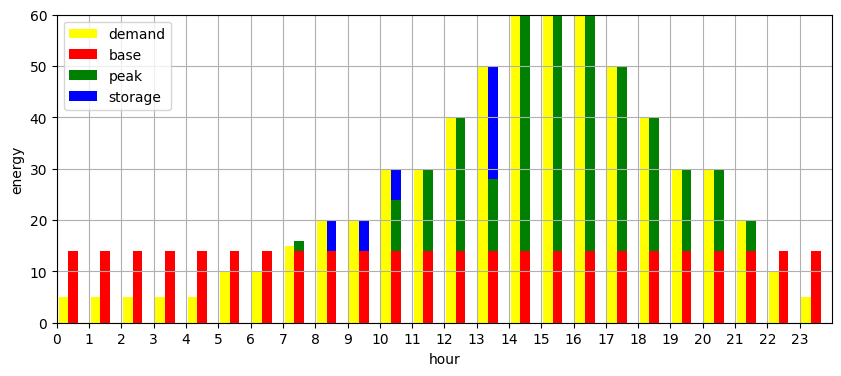

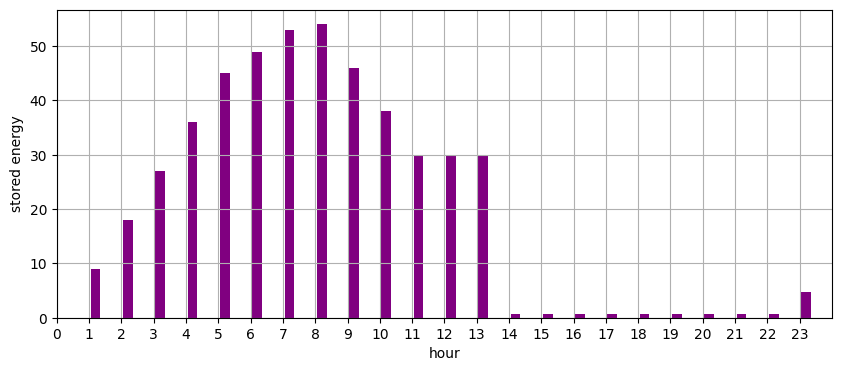

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_demands(n_base, n_peak_every_hour, storage_take_every_hour, storage_state_every_hour):
    """
    n_base: number of active base power-plants
    n_peak_every_hour: a list containing the number of active peak power-plants (every hour)
    storage_take_every_hour: a list containing the amount of energy, which is taken from the storage (every hour)
    storage_state_every_hour: a list containing the amount of energy, which is stored in the storage (every hour)
    """
    # Demand plot
    T = 24
    margin = 0.2
    width = 0.3
    plt.figure(figsize=(10, 4))
    plt.bar([t + margin for t in range(T)], d, width=width, color='yellow')

    # - base power-plants
    bottom = np.zeros(T)
    g_base = np.array([e_base * n_base for t in range(T)])
    plt.bar([t + margin + width for t in range(T)],
            g_base,
            width=width,
            bottom=bottom,
            color='red')
    bottom += g_base

    # - peak power-plants
    g_peak = np.array([e_peak * n_peak_every_hour[t] for t in range(T)])
    plt.bar([t + margin + width for t in range(T)],
            g_peak,
            width=width,
            bottom=bottom,
            color='green')
    bottom += g_peak

    # - storage
    g_a_take = np.array([gamma * storage_take_every_hour[t] for t in range(T)])
    plt.bar([t + margin + width for t in range(T)],
            g_a_take,
            width=width,
            bottom=bottom,
            color='blue')
    bottom += g_a_take

    plt.xlabel("hour")
    plt.ylabel("energy")
    plt.legend(['demand', 'base', 'peak', 'storage'], ncol=1, loc=2)
    plt.xlim(0, 24)
    plt.xticks(range(24), [i % 24 for i in range(24)])
    plt.grid()

    # Storage plot.
    plt.figure(figsize=(10, 4))
    plt.xlim(0, 24)
    plt.xticks(range(24), [i % 24 for i in range(24)])
    plt.xlabel("hour")
    plt.ylabel("stored energy")
    plt.bar([t + margin for t in range(T)], [storage_state_every_hour[t] for t in range(T)], width=width, color='purple')
    plt.grid()

    plt.show()

# The optimal solution
n_base_opt = 2
n_peak_opt = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5, 8, 13, 7, 23, 23, 23, 18, 13, 8, 8, 3, 0, 0]
storage_take_opt = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 8.0, 7.999999999999973, 0.0, 0.0, 29.333333333333275, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
storage_state_opt = [0.0, 9.0, 17.999999999999773, 26.99999999999942, 35.999999999999, 44.99999999999851, 48.999999999997975, 52.99999999999757, 53.999999999997, 45.999999999997, 37.999999999997, 29.99999999999703, 29.999999999997026, 29.999999999997026, 0.6666666666637511, 0.6666666666637511, 0.6666666666637511, 0.6666666666637511, 0.6666666666637511, 0.6666666666637511, 0.6666666666637511, 0.6666666666637511, 0.6666666666637511, 4.666666666663695]

# TODO: visualize your solution
# Call this function with
# - the number of base power-plants to be activated,
# - list of the numbers of the peak power-plants to be activated (every hour),
# - list containing the amount of power taken from the storage (every hour),
# - list containing the amount of energy in the storage (every hour)
plot_demands(n_base_opt, n_peak_opt, storage_take_opt, storage_state_opt)